# Displaying tif data

## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

Load the s3 utility fuctions to load/upload files

In [2]:
import sys

sys.path.append("../utils")
from s3 import S3Bucket

## Create an instance of the S3Bucket class

Replace the credentials path with your own.

### For Windows users

In [3]:
credentials_path = r"C:\Users\Jules\.aws\\"

### For MacOs and linux users

In [4]:
credentials_path = (
    r"~/.aws/"  # I'm not sure about the path here for linux or MacOs users.
)

### Load credentials

In [4]:
# The following code is to get the credentials from the .aws folder
# r is to avoid the \ being interpreted as an escape character

with open(credentials_path + "credentials", "r") as f:
    lines = f.readlines()
    for line in lines:
        if "aws_access_key_id" in line:
            aws_access_key_id = line.split("=")[1].strip()
        if "aws_secret_access_key" in line:
            aws_secret_key = line.split("=")[1].strip()

with open(credentials_path + "config", "r") as f:
    lines = f.readlines()
    for line in lines:
        if "region" in line:
            region_name = line.split("=")[1].strip()

bucket_names = ["alert-api", "risk"]

s3 = S3Bucket(
    bucket_name=bucket_names[1],
    endpoint_url="https://s3." + region_name + ".io.cloud.ovh.net/",
    region_name=region_name,
    aws_access_key_id=aws_access_key_id,
    aws_secret_key=aws_secret_key,
)

### Check the files in the bucket

In [5]:
_ = s3.list_files()

List all different file extensions in the bucket


In [6]:
file_extensions = []
for file in _:
    file_extensions.append(file.split(".")[-1])
file_extensions = list(set(file_extensions))
print(f"File extensions in the bucket: \n {file_extensions}")

File extensions in the bucket: 
 ['dbf', 'zip', 'nc', 'TFw', 'tfw', 'txt', 'SAMPLE', 'geojson', 'sld', 'ovr', 'gdb/gdb', 'json', 'tif', 'shp', 'prj', 'lyr', 'xml', 'gdbtable', 'gdbindexes', 'gpkg', 'gdbtablx', 'pdf', 'xls', 'DS_Store', 'hdf', 'cpg', 'qml', 'spx', 'shx', 'atx', 'gdb/timestamps', 'freelist', 'csv', 'doc', 'TIF']


We will study the .tif files which are raster files.

In [7]:
tif_files = s3.list_files(pattern=".tif")

# some files have many .extensions, so we only keep the files whose name ends with .tif
tif_files = [file for file in tif_files if file.endswith(".tif")]
print(f"Number of tif files: {len(tif_files)}")

Number of tif files: 534


In [8]:
tif_files[10]

'SMI/2009/sminx_m_euu_20090121_t.tif'

## Tif analysis process

### Downloading a file from the bucket

In [9]:
file_name = "test.tif"
s3.download_file(tif_files[10], file_name)

### Load the tif file as a rasterio object

Display base information about the dataset according to the rasterio documentation (https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html)


In [10]:
def display_tif_info(file_name):
    with rasterio.open(file_name) as dataset:
        print("Information about the TIFF file:")
        print("--------------------")
        # TODO: add more information about the file
        print(f"File name: {dataset.name}")
        print(f"Data type: {dataset.dtypes[0]}")
        print(f"Number of raster bands: {dataset.count}")
        print(f"Dimensions: {dataset.width} x {dataset.height}")

        print("\nGeographic information:")
        print("--------------------")
        print(f"Reference coordinate system: {dataset.crs}")
        print(f"Spatial coordinates of the corners: {dataset.bounds}")
        print(f"Spatial resolution: {dataset.res}")
        print(
            f"Geographic coordinates of the dataset's center (lon, lat): {dataset.lnglat()}"
        )
        # TODO: find how to get the geographic coordinates of any points, not only the center

        print(f"Transform matrix: \n{dataset.transform}\n")

        # Read the lattiude and longitude coordinates from the dataset
        # These coordinates
        lat = dataset.xy(0, 0)[1]
        lon = dataset.xy(0, 0)[0]

        print(
            f"Geographic coordinates of the top left corner relative to the CRS (lon, lat): {dataset.transform * (lat, lon)}"
        )

In [11]:
display_tif_info(file_name)

Information about the TIFF file:
--------------------
File name: test.tif
Data type: float32
Number of raster bands: 1
Dimensions: 1000 x 950

Geographic information:
--------------------
Reference coordinate system: EPSG:3035
Spatial coordinates of the corners: BoundingBox(left=2500000.0, bottom=750000.0, right=7500000.0, top=5500000.0)
Spatial resolution: (5000.0, 5000.0)
Geographic coordinates of the dataset's center (lon, lat): (19.670050132240075, 50.83184846792664)
Transform matrix: 
| 5000.00, 0.00, 2500000.00|
| 0.00,-5000.00, 5500000.00|
| 0.00, 0.00, 1.00|

Geographic coordinates of the top left corner relative to the CRS (lon, lat): (27490000000.0, -12507000000.0)


### Explanation of the cells above

```python	
>>> dataset.bounds
BoundingBox(left=358485.0, bottom=4028985.0, right=590415.0, top=4265115.0)
```
Means that  the map covers the world from 358485 meters (in this case) to 590415 meters, left to right, and 4028985 meters to 4265115 meters bottom to top. It covers a region 231.93 kilometers wide by 236.13 kilometers high. (https://rasterio.readthedocs.io/en/latest/quickstart.html)

You can check on this website that the coordinates of the dataset's center are correct: https://www.latlong.net/Show-Latitude-Longitude.html
For instance, (-61.407080232765665, 16.172103685047677) corresponds to Guadeloupe. 

### Plot the raster data

We can check whether the location found through the coordinates is correct by plotting the dataset on a map.

In [12]:
def plot_tif(file_name):
    with rasterio.open(file_name) as dataset:
        plt.figure(figsize=(5, 5))
        plt.imshow(dataset.read(1), cmap="viridis")
        plt.colorbar(label="Value, unit = ?")
        plt.title(f"Plot of {file_name}, with CRS {dataset.crs}")
        plt.tight_layout()
        plt.show()

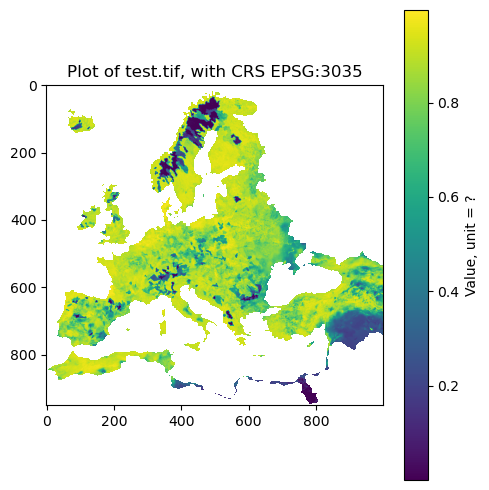

In [13]:
plot_tif(file_name)

Plot different files at the same time to compare them.

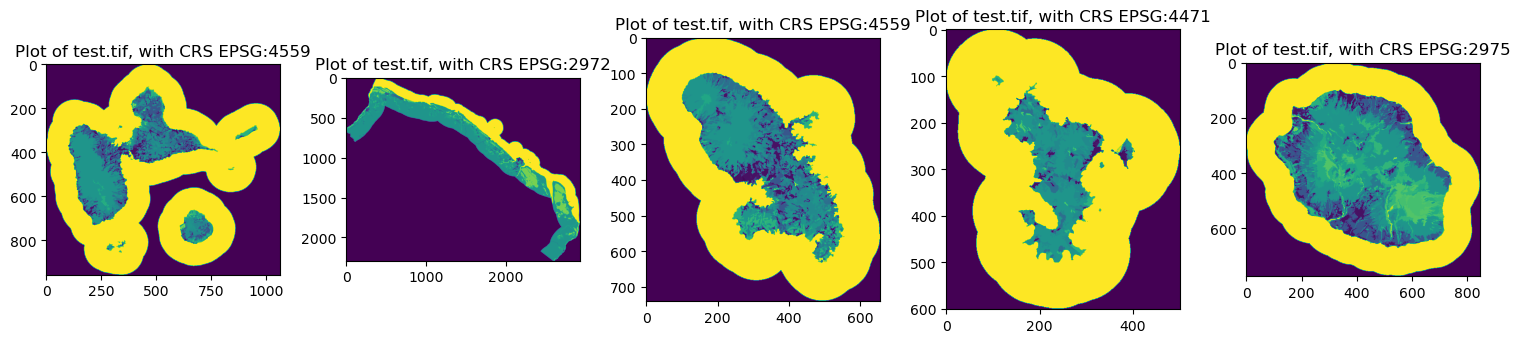

In [19]:
file_name = "test.tif"
fig, axs = plt.subplots(1, 5, figsize=(15, 15))

for i in range(5):
    s3.download_file(tif_files[i], file_name)
    with rasterio.open(file_name) as dataset:
        axs[i].imshow(dataset.read(1), cmap="viridis")
        axs[i].set_title(f"Plot of {file_name}, with CRS {dataset.crs}")

plt.tight_layout()
plt.show()

### Retroproject the coordinates

In [14]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [15]:
target_crs = "EPSG:4326"

It uses functions from rasterio.warp, which can be found here
1) https://rasterio.readthedocs.io/en/stable/api/rasterio.warp.html#rasterio.warp.calculate_default_transform
2) https://rasterio.readthedocs.io/en/stable/api/rasterio.warp.html#rasterio.warp.reproject

The reprojection uses the example from the documentation, which can be found here:
https://rasterio.readthedocs.io/en/latest/topics/reproject.html


In [16]:
with rasterio.open(file_name) as source:
    # get the output dimensions and transform for the reprojection
    transform, width, height = calculate_default_transform(
        source.crs, target_crs, source.width, source.height, *source.bounds
    )  # the error for tif file 10 might be here

    # store the metadata of the tiff dataset
    kwargs = source.meta.copy()
    kwargs.update(
        {
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height,
        }
    )

    # create the output file
    output_file_name = file_name.split(".")[0] + "_reprojected.tif"
    with rasterio.open(output_file_name, "w", **kwargs) as target:
        # reproject each band in the tif file
        for i in range(1, source.count + 1):
            reproject(
                source=rasterio.band(source, i),
                destination=rasterio.band(target, i),
                src_transform=source.transform,
                src_crs=source.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest,  # the error for tif file 10 might be here
            )

Compare the input and output file to check if the reprojection was successful.

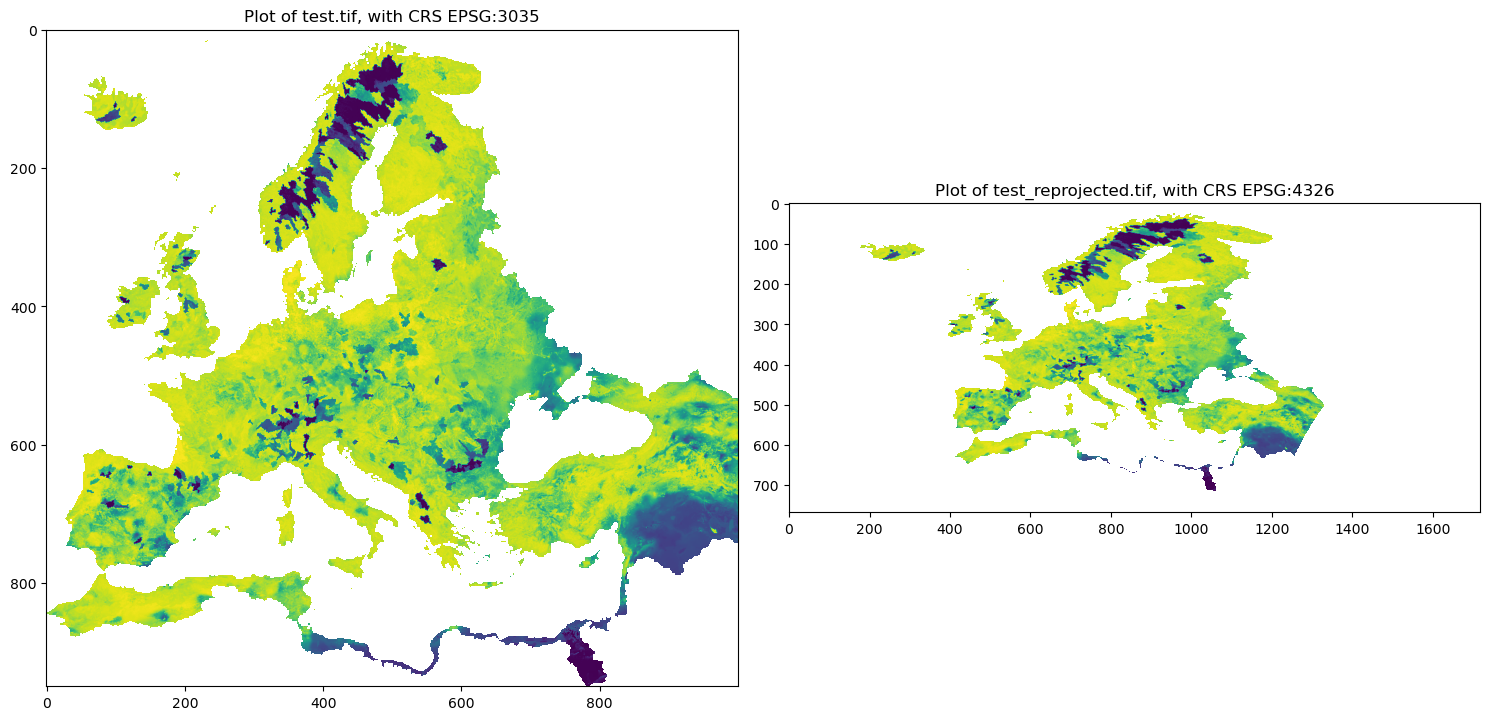

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

with rasterio.open(file_name) as dataset:
    axs[0].imshow(dataset.read(1), cmap="viridis")
    axs[0].set_title(f"Plot of {file_name}, with CRS {dataset.crs}")

with rasterio.open(output_file_name) as dataset:
    axs[1].imshow(dataset.read(1), cmap="viridis")
    axs[1].set_title(f"Plot of {output_file_name}, with CRS {dataset.crs}")

plt.tight_layout()
plt.show()

Get information about the input and output tif files to have a better understanding of the transformation process.

In [48]:
print("ORIGINAL FILE:")
display_tif_info(file_name)
print("\n!!!!!!!!!!!!!!!!!!!!!!\nREPROJECTED FILE:")
display_tif_info(output_file_name)

ORIGINAL FILE:
Information about the TIFF file:
--------------------
File name: test2.tif
Data type: float32
Number of raster bands: 1
Dimensions: 1000 x 950

Geographic information:
--------------------
Reference coordinate system: EPSG:3035
Spatial coordinates of the corners: BoundingBox(left=2500000.0, bottom=750000.0, right=7500000.0, top=5500000.0)
Spatial resolution: (5000.0, 5000.0)
Geographic coordinates of the dataset's center (lon, lat): (19.670050132240075, 50.83184846792664)
Transform matrix: 
| 5000.00, 0.00, 2500000.00|
| 0.00,-5000.00, 5500000.00|
| 0.00, 0.00, 1.00|

Geographic coordinates of the top left corner relative to the CRS (lon, lat): (27490000000.0, -12507000000.0)

!!!!!!!!!!!!!!!!!!!!!!
REPROJECTED FILE:
Information about the TIFF file:
--------------------
File name: test2_reprojected.tif
Data type: float32
Number of raster bands: 1
Dimensions: 1718 x 768

Geographic information:
--------------------
Reference coordinate system: EPSG:4326
Spatial coordinate

Geographic coordinates of the dataset's center should remain almost the same, errors are due to the projection approximation.

## TODO: 
1) Understand why the spatial resolution drastically changes when retroprojecting the coordinates.
2) Compare the spatial coordinates of the corners of two neighboring datasets to see if everything is consistent.
3) Understand why the tif file of Europe does not work well with reprojection.
